# Example of using NUTS

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from nuts_pytorch import nuts6

## Toy example

As an example let's choose the following two-dimensional target distribution
$$ p(x, y) = \exp\left( -20(y - x^2 - x - 1)^2 - x^2 \right). $$
This is a notoriously difficult distribution to sample, often used as a benchmark for sampling methods. For example, with plain Markov Chain Monte Carlo you'd have a bad time sampling this.

The `nuts6` function needs the logarithm of the target probability density function (PDF).

In [2]:
def target(theta):
    '''
    Arguments:
    - theta: variables of the PDF
    Returns:
    Log of the target PDF
    '''
    x, y = theta[0], theta[1]
    log_p = -20 * (y - x**2 - x - 1)**2 - x**2
    return log_p

Draw $1000$ samples from this distribution

find_reasonable_epsilon = 0.25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19999/19999 [00:17<00:00, 1153.73it/s]


Final epsilon = 0.1829909139826994
samples.shape = torch.Size([10000, 2])


Text(0, 0.5, 'y')

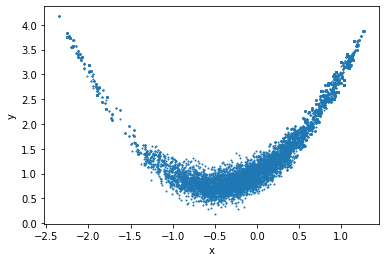

In [3]:
theta_0 = torch.tensor([0, 1]) # Initial point for the sampler
samples = nuts6(target, 10000, 10000, theta_0)
print('samples.shape =', samples.shape)
plt.scatter(*samples.T, s=1)
plt.xlabel('x')
plt.ylabel('y')

Now if you would plot the PDF you'd see that the samples cover the distribution nicely. Now we can compute, for example, the mean of the variables

In [4]:
samples.mean(axis=0)

tensor([0.0390, 1.6400], dtype=torch.float64)

These would be the approximations to the true means $E[X]$ and $E[Y]$ if $(X,Y)$ followed the distribution $p(x,y)$.

## Wilson loop model example

The data points are $\{(L_i, V_i, \sigma_i)\}$, $i=1\ldots n$ where  
$L_i = $ distance between quarks (for $i$th data point)  
$V_i = $ (regularized) quark potential for separation $L_i$  
$\sigma_i = $ the uncertainty/standard deviation of the $i$th measurement  
In the toy data case, these are provided by the `AdSBHDataset`-class:

In [5]:
import torch.nn as nn
from dataset import AdSBHDataset
from model import *
from constants import dtype

L = tensor([0.3236, 0.4967, 0.1587, 0.3500, 0.1165, 0.6073, 0.3330, 0.4897, 0.5797,
        0.5321, 0.2527, 0.0690, 0.2473, 0.3183, 0.3690, 0.3107, 0.5081, 0.1946,
        0.4619, 0.4419], dtype=torch.float64)
V = tensor([  0.0000,   0.0000,  -2.8434,   0.0000,  -6.0750,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000, -14.5239,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,  -1.2471,   0.0000,   0.0000],
       dtype=torch.float64)
sigma = tensor([0.9543, 0.9485, 0.8530, 0.7222, 0.7449, 0.8859, 0.5309, 0.5764, 0.9635,
        0.9472, 0.6334, 0.8959, 0.5009, 0.6536, 0.6894, 0.9651, 0.9257, 0.7034,
        0.9566, 0.9866], dtype=torch.float64)


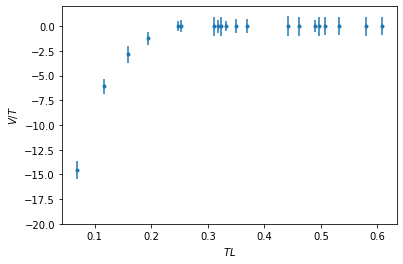

In [6]:
dataset = AdSBHDataset(N=20, threshold=0.0)
plt.errorbar(dataset.L, dataset.V, yerr=dataset.sigma, fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.ylim(-20, 2)
print('L =', dataset.L)
print('V =', dataset.V)
print('sigma =', dataset.sigma)

The model has the following parameters:  
* `a`: list of numbers which determine the $f(z)$-metric component
* `b`: list of numbers which determine the $g(z)$-metric component
* `coef`: the number ($R^2/(2\pi\alpha'$)) which multiplies the quark potential $V$. This is set to $1.0$ by default in the toy dataset
* `shift`: the constant shift of the potential $V$. This is set to $0.0$ by default in the toy dataset
We don't have to bother right now with `coef` and `shift`. They are relevant when we start to work with real data where we do not necessarily know $R$ or $\alpha'$ and the data might be shifted if it comes from a lattice simulation.

The purpose of the model is to compute the potential for a given width. That is, $L_i \mapsto V_i$. This calculation depends the above parameters.

Let's choose a normal likelihood and prior for parameters:
$$
p(data|a,b) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi}\sigma_i}\exp\left(-\frac{(V_i - V_i^{(pred)})^2}{2\sigma_i^2}\right) \ ,
$$
where $V_i^{(pred)} = model(V_i)$ is the model predicted potential for quark separation $L_i$. Let's take a quite uninformative prior
$$
p(a,b) = \prod_{i=1}^N p(a_i) p(b_i) \\
p(a_i) = \frac{1}{\sqrt{2\pi}\sigma_i^{(a)}} \exp\left(-\frac{a_i^2}{2(\sigma_i^{(a)})^2}\right) \\
p(b_i) = \frac{1}{\sqrt{2\pi}\sigma_i^{(b)}} \exp\left(-\frac{b_i^2}{2(\sigma_i^{(b)})^2}\right) \ ,
$$
where we set $\sigma_i^{(a)} = \sigma_i^{(b)} = 1$, so that the priors are centered around zero. These priors are for each component of $a$ and $b$ separately.

In [7]:
def log_likelihood(a, b, logcoef, shift):
    try:
        # Predict potentials for dataset separations
        V_pred = predict(a, b, logcoef, shift, dataset.L)
    except AssertionError:
        # If we are in an illegal part of the parameter space, let's  return -inf
        # instead of raising an exception because it signals `find_reasonable_epsilon`
        # that those values are bad.
        return as_tensor(float('-inf'))
    # Compute the log likelihood (omitting constants)
    log_likelihood = -torch.sum((V_pred - dataset.V)**2 / (2 * dataset.sigma**2))
    return log_likelihood

In [8]:
N = 1

def target(theta):
    assert theta.shape == (2 * N + 2,)
    # Parameter values
    a = theta[:N]
    b = theta[N:2 * N]
    logcoef = theta[2 * N]
    shift = theta[2 * N + 1]
    ll = log_likelihood(a, b, logcoef, shift)
    # Compute the log prior (omitting constants)
    prior_sigma = 1
    log_prior = (-torch.sum(a**2 + b**2) - logcoef**2 - shift**2) / (2 * prior_sigma**2)
    # Return the total log posterior probability (again omitting constants)
    return ll + log_prior

In [9]:
target(torch.tensor([0.0, 0.0, 0.0, 0.0]))

tensor(-1.5857e-08, dtype=torch.float64)

In [10]:
target(torch.tensor([0.1, 0.1, 0.1, 0.1]))

tensor(-6.7602, dtype=torch.float64)

Let's try sampling the posterior! This will be a lot slower than the example though.

find_reasonable_epsilon = 0.0625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1999/1999 [42:36<00:00,  1.28s/it]


Final epsilon = 0.07248450078898055
samples.shape = torch.Size([1000, 4])


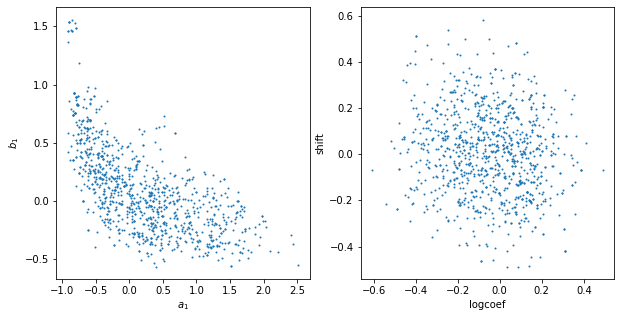

In [11]:
theta_0 = torch.tensor([0.1, 0.1, 0.0, 0.0]) # Initial point for the sampler
samples = nuts6(target, 1000, 1000, theta_0)
print('samples.shape =', samples.shape)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(*samples[:, :2].T, s=1)
axs[0].set_xlabel(f'$a_1$')
axs[0].set_ylabel(f'$b_1$')
axs[1].scatter(*samples[:, 2:].T, s=1)
axs[1].set_xlabel('logcoef')
axs[1].set_ylabel('shift');

In [12]:
samples.mean(axis=0)

tensor([ 0.1938,  0.0967, -0.0492,  0.0074], dtype=torch.float64)

These means seem reasonable: both `logcoef` and `shift` are close to zero which is their true value in the dataset. Values for `a` and `b` are also quite close to zero, maybe with a slight bias to the positive side. This could be explained by the fact that their distributions are skewed to the positive side because the $a_1 < -1$/$b_1 < -1$ region corresponds to illegal configurations of the metric.

In [14]:
N = 2

def target(theta):
    assert theta.shape == (2 * N + 2,)
    # Parameter values
    a = theta[:N]
    b = theta[N:2 * N]
    logcoef = theta[2 * N]
    shift = theta[2 * N + 1]
    ll = log_likelihood(a, b, logcoef, shift)
    # Compute the log prior (omitting constants)
    prior_sigma = 1
    log_prior = (-torch.sum(a**2 + b**2) - logcoef**2 - shift**2) / (2 * prior_sigma**2)
    # Return the total log posterior probability (again omitting constants)
    return ll + log_prior

In [15]:
target(torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

tensor(-11.8867, dtype=torch.float64)

In [17]:
theta_0 = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.0, 0.0]) # Initial point for the sampler
samples = nuts6(target, 1000, 1000, theta_0)
print('samples.shape =', samples.shape)

find_reasonable_epsilon = 0.03125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1999/1999 [1:58:41<00:00,  3.56s/it]

Final epsilon = 0.055823573164641135
samples.shape = torch.Size([1000, 6])


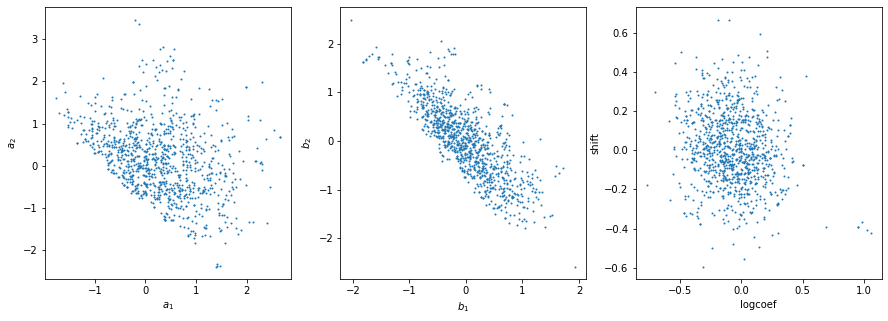

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(*samples[:, :2].T, s=1)
axs[0].set_xlabel(f'$a_1$')
axs[0].set_ylabel(f'$a_2$')
axs[1].scatter(*samples[:, 2:4].T, s=1)
axs[1].set_xlabel(f'$b_1$')
axs[1].set_ylabel(f'$b_2$')
axs[2].scatter(*samples[:, 4:].T, s=1)
axs[2].set_xlabel('logcoef')
axs[2].set_ylabel('shift');